In [1]:
from pathlib import Path
import sys
sys.path.append("/clusterdata/uqxtan9/Xiao/HisToGene")

In [2]:
import os
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from vis_model import HisToGene
from utils import *
from predict import model_predict, sr_predict
from dataset import ViT_HER2ST, ViT_SKIN

In [3]:
import pandas as pd

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import read_tiff
import numpy as np
import torchvision
import torchvision.transforms as transforms
import scanpy as sc
from utils import get_data
import os
import glob
from PIL import Image
import pandas as pd 
import scprep as scp
from PIL import ImageFile
import seaborn as sns
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

BCELL = ['CD19', 'CD79A', 'CD79B', 'MS4A1']
TUMOR = ['FASN']
CD4T = ['CD4']
CD8T = ['CD8A', 'CD8B']
DC = ['CLIC2', 'CLEC10A', 'CD1B', 'CD1A', 'CD1E']
MDC = ['LAMP3']
CMM = ['BRAF', 'KRAS']
IG = {'B_cell':BCELL, 'Tumor':TUMOR, 'CD4+T_cell':CD4T, 'CD8+T_cell':CD8T, 'Dendritic_cells':DC, 
        'Mature_dendritic_cells':MDC, 'Cutaneous_Malignant_Melanoma':CMM}
MARKERS = []
for i in IG.values():
    MARKERS+=i
LYM = {'B_cell':BCELL, 'CD4+T_cell':CD4T, 'CD8+T_cell':CD8T}

class STDataset(torch.utils.data.Dataset):
    """Some Information about STDataset"""
    def __init__(self, adata, img_path, diameter=177.5, train=True):
        super(STDataset, self).__init__()

        self.exp = adata.X.toarray()
        self.im = read_tiff(img_path)
        self.r = np.ceil(diameter/2).astype(int)
        self.train = train
        # self.d_spot = self.d_spot if self.d_spot%2==0 else self.d_spot+1
        self.transforms = transforms.Compose([
            transforms.ColorJitter(0.5,0.5,0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=180),
            transforms.ToTensor()
        ])
        self.centers = adata.obsm['spatial']
        self.pos = adata.obsm['position_norm']
    def __getitem__(self, index):
        exp = self.exp[index]
        center = self.centers[index]
        x, y = center
        patch = self.im.crop((x-self.r, y-self.r, x+self.r, y+self.r))
        exp = torch.Tensor(exp)
        mask = exp!=0
        mask = mask.float()
        if self.train:
            patch = self.transforms(patch)
        pos = torch.Tensor(self.pos[index])
        return patch, pos, exp, mask

    def __len__(self):
        return len(self.centers)



class HER2ST(torch.utils.data.Dataset):
    """Some Information about HER2ST"""
    def __init__(self,train=True,gene_list=None,ds=None,fold=0):
        super(HER2ST, self).__init__()
        self.cnt_dir = 'data/her2st/data/ST-cnts'
        self.img_dir = 'data/her2st/data/ST-imgs'
        self.pos_dir = 'data/her2st/data/ST-spotfiles'
        self.lbl_dir = 'data/her2st/data/ST-pat/lbl'
        self.r = 224//2
        # gene_list = list(np.load('data/her_hvg.npy',allow_pickle=True))
        gene_list = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
        self.gene_list = gene_list
        names = os.listdir(self.cnt_dir)
        names.sort()
        names = [i[:2] for i in names]
        self.train = train
  
        # samples = ['A1','B1','C1','D1','E1','F1','G2','H1']
        samples = names
        te_names = [samples[fold]]
        tr_names = list(set(samples)-set(te_names))
        if train:
            # names = names[1:33]
            # names = names[1:33] if self.cls==False else ['A1','B1','C1','D1','E1','F1','G2']
            names = tr_names
        else:
            # names = [names[33]]
            # names = ['A1']
            # names = [ds] if ds else ['H1']
            names = te_names
        print('Loading imgs...')
        self.img_dict = {i:self.get_img(i) for i in names}
        print('Loading metadata...')
        self.meta_dict = {i:self.get_meta(i) for i in names}

        # self.gene_set = self.get_overlap(self.meta_dict,gene_list)
        # print(len(self.gene_set))
        # np.save('data/her_hvg',self.gene_set)
        # quit()
        self.gene_set = list(gene_list)
        self.exp_dict = {i:scp.transform.log(scp.normalize.library_size_normalize(m[self.gene_set].values)) for i,m in self.meta_dict.items()}
        self.center_dict = {i:np.floor(m[['pixel_x','pixel_y']].values).astype(int) for i,m in self.meta_dict.items()}
        self.loc_dict = {i:m[['x','y']].values for i,m in self.meta_dict.items()}


        self.lengths = [len(i) for i in self.meta_dict.values()]
        self.cumlen = np.cumsum(self.lengths)
        self.id2name = dict(enumerate(names))

        self.transforms = transforms.Compose([
            transforms.ColorJitter(0.5,0.5,0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=180),
            transforms.ToTensor()
        ])
    def __getitem__(self, index):
        i = 0
        while index>=self.cumlen[i]:
            i += 1
        idx = index
        if i > 0:
            idx = index - self.cumlen[i-1]
        
        exp = self.exp_dict[self.id2name[i]][idx]
        center = self.center_dict[self.id2name[i]][idx]
        loc = self.loc_dict[self.id2name[i]][idx]

        # if self.cls or self.train==False:

        exp = torch.Tensor(exp)
        loc = torch.Tensor(loc)

        x, y = center
        patch = self.img_dict[self.id2name[i]].crop((x-self.r, y-self.r, x+self.r, y+self.r))
        if self.train:
            patch = self.transforms(patch)
        else:
            patch = transforms.ToTensor()(patch)

        if self.train:
            return patch, loc, exp
        else: 
            return patch, loc, exp, torch.Tensor(center)

    def __len__(self):
        return self.cumlen[-1]

    def get_img(self,name):
        pre = self.img_dir+'/'+name[0]+'/'+name
        fig_name = os.listdir(pre)[0]
        path = pre+'/'+fig_name
        im = Image.open(path)
        return im

    def get_cnt(self,name):
        path = self.cnt_dir+'/'+name+'.tsv'
        df = pd.read_csv(path,sep='\t',index_col=0)
        return df

    def get_pos(self,name):
        path = self.pos_dir+'/'+name+'_selection.tsv'
        # path = self.pos_dir+'/'+name+'_labeled_coordinates.tsv'
        df = pd.read_csv(path,sep='\t')

        x = df['x'].values
        y = df['y'].values
        x = np.around(x).astype(int)
        y = np.around(y).astype(int)
        id = []
        for i in range(len(x)):
            id.append(str(x[i])+'x'+str(y[i])) 
        df['id'] = id

        return df

    def get_lbl(self,name):
        # path = self.pos_dir+'/'+name+'_selection.tsv'
        path = self.lbl_dir+'/'+name+'_labeled_coordinates.tsv'
        df = pd.read_csv(path,sep='\t')

        x = df['x'].values
        y = df['y'].values
        x = np.around(x).astype(int)
        y = np.around(y).astype(int)
        id = []
        for i in range(len(x)):
            id.append(str(x[i])+'x'+str(y[i])) 
        df['id'] = id
        df.drop('pixel_x', inplace=True, axis=1)
        df.drop('pixel_y', inplace=True, axis=1)
        df.drop('x', inplace=True, axis=1)
        df.drop('y', inplace=True, axis=1)

        return df

    def get_meta(self,name,gene_list=None):
        cnt = self.get_cnt(name)
        pos = self.get_pos(name)
        meta = cnt.join((pos.set_index('id')))
        self.max_x = 0
        self.max_y = 0
        loc = meta[['x','y']].values
        self.max_x = max(self.max_x, loc[:,0].max())
        self.max_y = max(self.max_y, loc[:,1].max())
        return meta

    def get_overlap(self,meta_dict,gene_list):
        gene_set = set(gene_list)
        for i in meta_dict.values():
            gene_set = gene_set&set(i.columns)
        return list(gene_set)

class ViT_HER2ST(torch.utils.data.Dataset):
    """Some Information about HER2ST"""
    def __init__(self,train=True,gene_list=None,ds=None,sr=False,fold=0):
        super(ViT_HER2ST, self).__init__()

        self.cnt_dir = 'data/her2st/data/ST-cnts'
        self.img_dir = 'data/her2st/data/ST-imgs'
        self.pos_dir = 'data/her2st/data/ST-spotfiles'
        self.lbl_dir = 'data/her2st/data/ST-pat/lbl'
        self.r = 224//4

        # gene_list = list(np.load('data/her_hvg.npy',allow_pickle=True))
        gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", 
           "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]
        self.gene_list = gene_list
        names = os.listdir(self.cnt_dir)
        names.sort()
        names = [i[:2] for i in names]
        self.train = train
        self.sr = sr
        
        # samples = ['A1','B1','C1','D1','E1','F1','G2','H1']
        samples = names[1:33]

        te_names = [samples[fold]]
        tr_names = list(set(samples)-set(te_names))

        if train:
            # names = names[1:33]
            # names = names[1:33] if self.cls==False else ['A1','B1','C1','D1','E1','F1','G2']
            names = tr_names
        else:
            # names = [names[33]]
            # names = ['A1']
            # names = [ds] if ds else ['H1']
            names = te_names

        print('Loading imgs...')
        self.img_dict = {i:torch.Tensor(np.array(self.get_img(i))) for i in names}
        print('Loading metadata...')
        self.meta_dict = {i:self.get_meta(i) for i in names}


        self.gene_set = list(gene_list)
        self.exp_dict = {i:scp.transform.log(scp.normalize.library_size_normalize(m[self.gene_set].values)) for i,m in self.meta_dict.items()}
        self.center_dict = {i:np.floor(m[['pixel_x','pixel_y']].values).astype(int) for i,m in self.meta_dict.items()}
        self.loc_dict = {i:m[['x','y']].values for i,m in self.meta_dict.items()}


        self.lengths = [len(i) for i in self.meta_dict.values()]
        self.cumlen = np.cumsum(self.lengths)
        self.id2name = dict(enumerate(names))

        self.transforms = transforms.Compose([
            transforms.ColorJitter(0.5,0.5,0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=180),
            transforms.ToTensor()
        ])

    def filter_helper(self):
        a = np.zeros(len(self.gene_list))
        n = 0
        for i,exp in self.exp_dict.items():
            n += exp.shape[0]
            exp[exp>0] = 1
            for j in range((len(self.gene_list))):
                a[j] += np.sum(exp[:,j])


    def __getitem__(self, index):
        i = index
        im = self.img_dict[self.id2name[i]]
        im = im.permute(1,0,2)
        # im = torch.Tensor(np.array(self.im))
        exps = self.exp_dict[self.id2name[i]]
        centers = self.center_dict[self.id2name[i]]
        loc = self.loc_dict[self.id2name[i]]
        positions = torch.LongTensor(loc)
        patch_dim = 3 * self.r * self.r * 4

        if self.sr:
            centers = torch.LongTensor(centers)
            max_x = centers[:,0].max().item()
            max_y = centers[:,1].max().item()
            min_x = centers[:,0].min().item()
            min_y = centers[:,1].min().item()
            r_x = (max_x - min_x)//30
            r_y = (max_y - min_y)//30

            centers = torch.LongTensor([min_x,min_y]).view(1,-1)
            positions = torch.LongTensor([0,0]).view(1,-1)
            x = min_x
            y = min_y

            while y < max_y:  
                x = min_x            
                while x < max_x:
                    centers = torch.cat((centers,torch.LongTensor([x,y]).view(1,-1)),dim=0)
                    positions = torch.cat((positions,torch.LongTensor([x//r_x,y//r_y]).view(1,-1)),dim=0)
                    x += 56                
                y += 56
            
            centers = centers[1:,:]
            positions = positions[1:,:]

            n_patches = len(centers)
            patches = torch.zeros((n_patches,patch_dim))
            for i in range(n_patches):
                center = centers[i]
                x, y = center
                patch = im[(x-self.r):(x+self.r),(y-self.r):(y+self.r),:]
                patches[i] = patch.flatten()


            return patches, positions, centers

        else:    
            n_patches = len(centers)
            
            patches = torch.zeros((n_patches,patch_dim))
            exps = torch.Tensor(exps)


            for i in range(n_patches):
                center = centers[i]
                x, y = center
                patch = im[(x-self.r):(x+self.r),(y-self.r):(y+self.r),:]
                patches[i] = patch.flatten()

            if self.train:
                return patches, positions, exps
            else: 
                return patches, positions, exps, torch.Tensor(centers)
        
    def __len__(self):
        return len(self.exp_dict)

    def get_img(self,name):
        pre = self.img_dir+'/'+name[0]+'/'+name
        fig_name = os.listdir(pre)[0]
        path = pre+'/'+fig_name
        im = Image.open(path)
        return im

    def get_cnt(self,name):
        path = self.cnt_dir+'/'+name+'.tsv'
        df = pd.read_csv(path,sep='\t',index_col=0)

        return df

    def get_pos(self,name):
        path = self.pos_dir+'/'+name+'_selection.tsv'
        # path = self.pos_dir+'/'+name+'_labeled_coordinates.tsv'
        df = pd.read_csv(path,sep='\t')

        x = df['x'].values
        y = df['y'].values
        x = np.around(x).astype(int)
        y = np.around(y).astype(int)
        id = []
        for i in range(len(x)):
            id.append(str(x[i])+'x'+str(y[i])) 
        df['id'] = id

        return df

    def get_lbl(self,name):
        # path = self.pos_dir+'/'+name+'_selection.tsv'
        path = self.lbl_dir+'/'+name+'_labeled_coordinates.tsv'
        df = pd.read_csv(path,sep='\t')

        x = df['x'].values
        y = df['y'].values
        x = np.around(x).astype(int)
        y = np.around(y).astype(int)
        id = []
        for i in range(len(x)):
            id.append(str(x[i])+'x'+str(y[i])) 
        df['id'] = id
        df.drop('pixel_x', inplace=True, axis=1)
        df.drop('pixel_y', inplace=True, axis=1)
        df.drop('x', inplace=True, axis=1)
        df.drop('y', inplace=True, axis=1)

        return df

    def get_meta(self,name,gene_list=None):
        cnt = self.get_cnt(name)
        pos = self.get_pos(name)
        meta = cnt.join((pos.set_index('id')))

        return meta

    def get_overlap(self,meta_dict,gene_list):
        gene_set = set(gene_list)
        for i in meta_dict.values():
            gene_set = gene_set&set(i.columns)
        return list(gene_set)

In [5]:
import os
from argparse import ArgumentParser
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from transformer import ViT
from torch.optim.lr_scheduler import ReduceLROnPlateau

class FeatureExtractor(nn.Module):
    """Some Information about FeatureExtractor"""
    def __init__(self, backbone='resnet101'):
        super(FeatureExtractor, self).__init__()
        backbone = torchvision.models.resnet101(pretrained=True)
        layers = list(backbone.children())[:-1]
        self.backbone = nn.Sequential(*layers)
        # self.backbone = backbone
    def forward(self, x):
        x = self.backbone(x)
        return x

class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=4, backbone='resnet50', learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        backbone = torchvision.models.resnet50(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        num_target_classes = num_classes
        self.classifier = nn.Linear(num_filters, num_target_classes)
        # self.valid_acc = torchmetrics.Accuracy()
        self.learning_rate = learning_rate

    def forward(self, x):
        # use forward for inference/predictions
        embedding = self.feature_extractor(x)
        return embedding

    def training_step(self, batch, batch_idx):
        x, y = batch
        h = self.feature_extractor(x).flatten(1)
        h = self.classifier(h)
        logits = F.log_softmax(h, dim=1)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        h = self.feature_extractor(x).flatten(1)
        h = self.classifier(h)
        logits = F.log_softmax(h, dim=1)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        self.log('valid_loss', loss)
        self.log('valid_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        h = self.feature_extractor(x).flatten(1)
        h = self.classifier(h)
        logits = F.log_softmax(h, dim=1)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        self.log('test_loss', loss)
        self.log('test_acc', acc)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--lr', type=float, default=0.0001)
        return parser


class STModel(pl.LightningModule):
    def __init__(self, feature_model=None, n_genes=1000, hidden_dim=2048, learning_rate=1e-5, use_mask=False, use_pos=False, cls=False):
        super().__init__()
        self.save_hyperparameters()
        # self.feature_model = None
        if feature_model:
            # self.feature_model = ImageClassifier.load_from_checkpoint(feature_model)
            # self.feature_model.freeze()
            self.feature_extractor = ImageClassifier.load_from_checkpoint(feature_model)
        else:
            self.feature_extractor = FeatureExtractor()
        # self.pos_embed = nn.Linear(2, hidden_dim)
        self.pred_head = nn.Linear(hidden_dim, n_genes)
        
        self.learning_rate = learning_rate
        self.n_genes = n_genes

    def forward(self, patch, center):
        feature = self.feature_extractor(patch).flatten(1)
        h = feature
        pred = self.pred_head(F.relu(h))
        return pred

    def training_step(self, batch, batch_idx):
        patch, center, exp = batch
        pred = self(patch, center)
        loss = F.mse_loss(pred, exp)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        patch, center, exp = batch
        pred = self(patch, center)
        loss = F.mse_loss(pred, exp)
        self.log('valid_loss', loss)
        
    def test_step(self, batch, batch_idx):
        patch, center, exp, mask, label = batch
        if self.use_mask:
            pred, mask_pred = self(patch, center)
        else:
            pred = self(patch, center)

        loss = F.mse_loss(pred, exp)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--learning_rate', type=float, default=0.0001)
        return parser


class HisToGene(pl.LightningModule):
    def __init__(self, patch_size=112, n_layers=4, n_genes=1000, dim=1024, learning_rate=1e-4, dropout=0.1, n_pos=64):
        super().__init__()
        # self.save_hyperparameters()
        self.learning_rate = learning_rate
        patch_dim = 3*patch_size*patch_size
        self.patch_embedding = nn.Linear(patch_dim, dim)
        self.x_embed = nn.Embedding(n_pos,dim)
        self.y_embed = nn.Embedding(n_pos,dim)
        self.vit = ViT(dim=dim, depth=n_layers, heads=16, mlp_dim=2*dim, dropout = dropout, emb_dropout = dropout)

        self.gene_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_genes)
        )

    def forward(self, patches, centers):
        patches = self.patch_embedding(patches)
        centers_x = self.x_embed(centers[:,:,0])
        centers_y = self.y_embed(centers[:,:,1])
        x = patches + centers_x + centers_y
        h = self.vit(x)
        x = self.gene_head(h)
        return x

    def training_step(self, batch, batch_idx):        
        patch, center, exp = batch
        pred = self(patch, center)
        loss = F.mse_loss(pred, exp)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        patch, center, exp = batch
        pred = self(patch, center)
        loss = F.mse_loss(pred, exp)
        self.log('valid_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        patch, center, exp = batch
        pred = self(patch, center)
        loss = F.mse_loss(pred, exp)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--learning_rate', type=float, default=0.0001)
        return parser

def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g


def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

def calculate_correlation_2(attr_1, attr_2):
    r = stats.spearmanr(attr_1, 
                       attr_2)[0]
    return r

In [7]:
gene_list = ["PABPC1", "GNAS", "HSP90AB1", "TFF3", 
               "ATP1A1", "COX6C", "B2M", "FASN", 
               "ACTG1", "HLA-B"]

In [8]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", 
           "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

In [9]:
n_genes = len(gene_list)

In [10]:
cnt_dir = 'data/her2st/data/ST-cnts'
names = os.listdir(cnt_dir)
names.sort()
names = [i[:2] for i in names]

In [11]:
len(names)

36

In [ ]:
fold = 11
tag = '-htg_her2st_785_32_cv'

dataset = ViT_HER2ST(train=True, fold=fold)
train_loader = DataLoader(dataset, batch_size=1, num_workers=4, shuffle=True)
model = HisToGene(n_layers=8, n_genes=n_genes, learning_rate=1e-5)
trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader)
trainer.save_checkpoint("model/last_train_"+tag+'_'+str(fold)+".ckpt")

In [16]:
fold = 11
tag = '-htg_her2st_785_32_cv'

model = HisToGene.load_from_checkpoint("model/last_train_"+tag+'_'+str(fold)+".ckpt",n_layers=8, n_genes=n_genes, learning_rate=1e-5)
device = torch.device('cuda')
dataset = ViT_HER2ST(train=False,sr=False,fold=fold)
test_loader = DataLoader(dataset, batch_size=1, num_workers=4)
adata_pred, adata_truth = model_predict(model, test_loader, attention=False, device = device)
adata_pred = comp_tsne_km(adata_pred,4)

Loading imgs...
Loading metadata...



100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


In [17]:
adata_pred.var_names = gene_list
adata_truth.var_names = gene_list

In [18]:
adata_pred.to_df()

,COX6C,TTLL12,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
0,1.945840,1.089230,2.575592,2.563287,1.894998,1.983697,2.308305,2.916501,2.646744,2.416399,3.191280,2.808548,1.773631,2.564257
1,1.915774,1.143855,2.565233,2.575125,1.951237,2.068224,2.209699,2.895865,2.508235,2.479260,3.178086,2.800158,1.758799,2.590837
2,1.931649,1.137906,2.600096,2.593832,1.979227,1.950597,2.282361,2.910282,2.584694,2.449430,3.212530,2.804580,1.757494,2.609325
3,1.940102,1.121358,2.531515,2.565498,1.938142,1.978363,2.239977,2.897552,2.639470,2.454662,3.161328,2.818110,1.742519,2.627058
4,1.988741,1.127482,2.577840,2.646735,2.057627,1.974151,2.335850,2.903055,2.632266,2.438613,3.225013,2.858447,1.782035,2.606290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1.921911,1.114804,2.627405,2.596667,1.961645,2.034248,2.262314,2.912791,2.522980,2.430790,3.180986,2.812639,1.748954,2.610591
172,1.910880,1.138265,2.588789,2.587279,2.016263,1.983923,2.289774,2.913406,2.658746,2.451695,3.141338,2.848902,1.808295,2.572505
173,1.882402,1.100081,2.627000,2.578923,1.937596,1.987968,2.225319,2.948628,2.550081,2.453475,3.226101,2.795146,1.758592,2.593796
174,1.903308,1.078862,2.580989,2.553252,1.899713,2.000160,2.245370,2.906118,2.502790,2.449273,3.222308,2.784276,1.760655,2.619453


In [19]:
adata_truth.to_df()

,COX6C,TTLL12,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
0,2.388993,0.000000,2.689136,2.989721,2.388993,3.617770,2.989721,2.689136,2.989721,2.689136,0.000000,2.689136,2.388993,2.388993
1,2.824560,0.000000,3.125264,0.000000,2.824560,2.824560,0.000000,3.125264,2.824560,3.301247,3.125264,3.125264,0.000000,0.000000
2,0.000000,2.639270,2.639270,0.000000,2.639270,3.115726,0.000000,0.000000,3.240582,2.939801,3.337442,3.337442,0.000000,2.639270
3,0.000000,0.000000,2.678692,3.155206,2.678692,3.376933,2.678692,0.000000,2.678692,2.678692,3.280069,2.979266,0.000000,2.979266
4,2.554056,1.955619,2.729743,2.905565,2.554056,3.365942,2.254237,3.127198,2.729743,2.854480,3.097257,2.729743,2.905565,2.254237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.000000,0.000000,0.000000,0.000000,3.046148,3.523009,0.000000,0.000000,3.523009,3.046148,0.000000,3.046148,0.000000,0.000000
172,2.410626,1.936866,2.631799,3.108244,3.078305,3.187369,2.235377,2.410626,3.274468,3.108244,2.235377,2.886621,2.410626,2.631799
173,0.000000,0.000000,2.870252,2.569807,0.000000,3.170989,0.000000,2.569807,2.870252,3.267841,3.046148,3.267841,2.569807,3.046148
174,2.538860,0.000000,0.000000,2.936045,0.000000,2.839261,0.000000,3.315963,2.538860,3.191094,3.440849,2.538860,2.714532,2.714532


In [26]:
test_sample = names[fold]

In [29]:
pred_adata = adata_pred.copy()
test_dataset = adata_truth.copy()
df = pd.DataFrame()

for gene in pred_adata.var_names:
    cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
    df = df.append(pd.Series([gene, cor_val, test_sample, "His2gene"], 
                             index=["Gene", "Pearson correlation", "Slide", "Method"]),
                  ignore_index=True)

In [30]:
df

,Gene,Pearson correlation,Slide,Method
0,COX6C,0.309781,B6,His2gene
1,TTLL12,0.049354,B6,His2gene
2,PABPC1,-0.026237,B6,His2gene
3,GNAS,0.253401,B6,His2gene
4,HSP90AB1,0.220667,B6,His2gene
5,TFF3,-0.076952,B6,His2gene
6,ATP1A1,0.362958,B6,His2gene
7,B2M,0.027719,B6,His2gene
8,FASN,0.203445,B6,His2gene
9,SPARC,-0.036512,B6,His2gene


In [32]:
names

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'E1',
 'E2',
 'E3',
 'F1',
 'F2',
 'F3',
 'G1',
 'G2',
 'G3',
 'H1',
 'H2',
 'H3']

In [ ]:
df = pd.DataFrame()
for i in range(len(names)):
    fold = i
    test_sample = names[fold]
    print("process {}".format(test_sample))
    tag = '-htg_her2st_14_32_cv'

    dataset = ViT_HER2ST(train=True, fold=fold)
    train_loader = DataLoader(dataset, batch_size=1, num_workers=4, shuffle=True)
    model = HisToGene(n_layers=8, n_genes=n_genes, learning_rate=1e-5)
    trainer = pl.Trainer(gpus=1, max_epochs=100)
    trainer.fit(model, train_loader)
#     trainer.save_checkpoint("model/last_train_"+tag+'_'+str(fold)+".ckpt")

#     model = HisToGene.load_from_checkpoint("model/last_train_"+tag+'_'+str(fold)+".ckpt",n_layers=8, n_genes=n_genes, learning_rate=1e-5)
    device = torch.device('cuda')
    dataset = ViT_HER2ST(train=False,sr=False,fold=fold)
    test_loader = DataLoader(dataset, batch_size=1, num_workers=4)
    adata_pred, adata_truth = model_predict(model, test_loader, attention=False, device = device)
    
    adata_pred.var_names = gene_list
    adata_truth.var_names = gene_list
    
    pred_adata = adata_pred.copy()
    test_dataset = adata_truth.copy()

    for gene in pred_adata.var_names:
        cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
        df = df.append(pd.Series([gene, cor_val, test_sample, "His2gene"], 
                             index=["Gene", "Pearson correlation", "Slide", "Method"]),
                  ignore_index=True)
    del model
    torch.cuda.empty_cache()

process A1
Loading imgs...
Loading metadata...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Linear     | 38.5 M
1 | x_embed         | Embedding  | 65.5 K
2 | y_embed         | Embedding  | 65.5 K
3 | vit             | ViT        | 67.2 M
4 | gene_head       | Sequential | 16.4 K
-----------------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
423.432   Total estimated model params size (MB)


Epoch 99: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s, loss=1.28, v_num=431422]
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


process A2
Loading imgs...
Loading metadata...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | patch_embedding | Linear     | 38.5 M
1 | x_embed         | Embedding  | 65.5 K
2 | y_embed         | Embedding  | 65.5 K
3 | vit             | ViT        | 67.2 M
4 | gene_head       | Sequential | 16.4 K
-----------------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
423.432   Total estimated model params size (MB)


Epoch 99: 100%|██████████| 31/31 [00:05<00:00,  5.67it/s, loss=1.35, v_num=431422]
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


process A3
Loading imgs...


In [ ]:
df.to_csv("./histogene_cor.csv")

In [ ]:
sc.pl.spatial(adata_pred, img=None, color='FASN', spot_size=112, color_map='magma')

In [ ]:
adata_pred.to_df().to_csv("./histogene_pred.csv")

In [ ]:
adata_truth.to_df().to_csv("./histogene_truth.csv")

In [ ]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
r2_list = []
genes_list = []
sample_list = []
for gene in tumor_genes:
    library = "C1"
    r2 = stats.pearsonr(adata_truth[:,gene].to_df().values.flatten(), adata_pred[:,gene].to_df().values.flatten())[0] ** 2
    r2_list.append(r2)
    genes_list.append(gene)
    sample_list.append(library)
    print("finished sample: {}".format(library))

finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1


In [52]:
df = pd.DataFrame({"R2": r2_list,
                   "tumor_gene": genes_list,
                   "sample":sample_list})

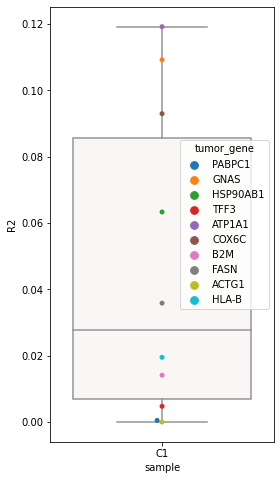

In [59]:
f, ax = plt.subplots(figsize=(4, 8))
sns.boxplot(x="sample", y="R2", data=df, palette="vlag")
sns.swarmplot(x="sample", y="R2", data=df, hue="tumor_gene")
plt.show()

In [60]:
dataset_sr = ViT_HER2ST(train=False,sr=True,fold=fold)
test_loader_sr = DataLoader(dataset_sr, batch_size=1, num_workers=2)
adata_sr = sr_predict(model,test_loader_sr,attention=False)
adata_sr = comp_tsne_km(adata_sr,4)
adata_sr.var_names = g

Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:19<00:00, 19.30s/it]


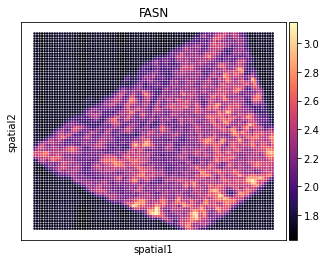

In [70]:
sc.pl.spatial(adata_sr, img=None, color='FASN', spot_size=56, color_map='magma')

In [62]:
adata_sr

AnnData object with n_obs × n_vars = 7410 × 10
    obs: 'kmeans'
    uns: 'pca', 'tsne'
    obsm: 'spatial', 'X_pca', 'X_tsne'
    varm: 'PCs'

In [63]:
adata_pred

AnnData object with n_obs × n_vars = 176 × 10
    obs: 'kmeans'
    uns: 'pca', 'tsne'
    obsm: 'spatial', 'X_pca', 'X_tsne'
    varm: 'PCs'

In [71]:
r_list = []
genes_list = []
sample_list = []
for gene in tumor_genes:
    library = "C1"
    r_v = stats.pearsonr(adata_truth[:,gene].to_df().values.flatten(), adata_pred[:,gene].to_df().values.flatten())[0]
    r_list.append(r_v)
    genes_list.append(gene)
    sample_list.append(library)
    print("finished sample: {}".format(library))

finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1
finished sample: C1


In [72]:
df = pd.DataFrame({"R": r_list,
                   "tumor_gene": genes_list,
                   "sample":sample_list})

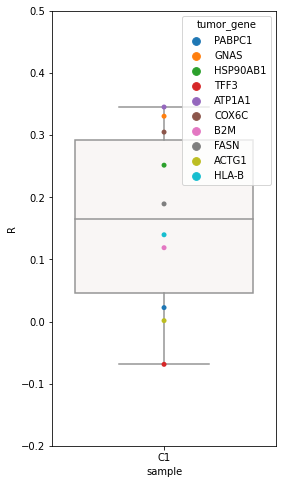

In [79]:
f, ax = plt.subplots(figsize=(4, 8))
sns.boxplot(x="sample", y="R", data=df, palette="vlag")
sns.swarmplot(x="sample", y="R", data=df, hue="tumor_gene")
ax.set_ylim([-0.2, 0.5]) 
plt.show()

In [66]:
img = Image.open("./data/her2st/data/ST-imgs/C/C1/5714_HE_BT_C1.jpg")

In [84]:
fold = [1,2]
tag = '-htg_her2st_785_32_cv'

dataset = ViT_HER2ST(train=True, fold=fold)
train_loader = DataLoader(dataset, batch_size=1, num_workers=4, shuffle=True)
model = HisToGene(n_layers=8, n_genes=10, learning_rate=1e-5)
trainer = pl.Trainer(gpus=1, max_epochs=100)
trainer.fit(model, train_loader)
trainer.save_checkpoint("model/last_train_"+tag+'_'+str(fold)+".ckpt")

TypeError: list indices must be integers or slices, not list

In [18]:
cnt_dir = 'data/her2st/data/ST-cnts'

In [19]:
names = os.listdir(cnt_dir)

In [20]:
names.sort()

In [21]:
names = [i[:2] for i in names]

In [22]:
names

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'E1',
 'E2',
 'E3',
 'F1',
 'F2',
 'F3',
 'G1',
 'G2',
 'G3',
 'H1',
 'H2',
 'H3']

In [23]:
samples = names[1:33]

In [24]:
te_names = [samples[11]]
tr_names = list(set(samples)-set(te_names))

In [25]:
te_names

['C1']

In [16]:
tr_names

['D1',
 'E1',
 'G2',
 'C6',
 'C1',
 'C4',
 'D6',
 'F2',
 'A2',
 'D4',
 'A4',
 'D5',
 'A6',
 'C3',
 'B6',
 'C5',
 'B4',
 'A5',
 'B5',
 'G1',
 'C2',
 'G3',
 'E2',
 'F1',
 'E3',
 'D2',
 'A3',
 'F3',
 'D3',
 'B3',
 'B2']

In [26]:
samples = pd.Series(names)
tr_names = samples.sample(frac=0.7, random_state=1)
training_index = samples.index.isin(tr_names.index)
te_names = samples[~training_index].copy()

In [27]:
tr_names

30    G1
34    H2
28    F2
3     A4
19    D2
17    C6
21    D4
23    D6
29    F3
26    E3
27    F1
33    H1
24    E1
25    E2
4     A5
2     A3
14    C3
10    B5
32    G3
22    D5
31    G2
20    D3
18    D1
6     B1
13    C2
dtype: object

In [28]:
te_names

0     A1
1     A2
5     A6
7     B2
8     B3
9     B4
11    B6
12    C1
15    C4
16    C5
35    H3
dtype: object